# Genetic Algorithm implementation for elastic optical networks

Author: Carlos Natalino <carlos.natalino@chalmers.se>

For reference regarding the problem, please check https://ieeexplore.ieee.org/abstract/document/6503559

## imports

python libraries used:
- numpy
- matplotlib
- networkx
- pandas

In [1]:
import random
import operator
import copy
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import *

from IPython import display

%matplotlib inline
%config InlineBackend.figure_formats = ['svg'] # high quality visualization

### Implementation of the genetic algorithm based on the tutorial available at:
https://github.com/ezstoltz/genetic-algorithm/blob/master/genetic_algorithm_TSP.ipynb

### definition of the modulation formats
Reference: https://ieeexplore.ieee.org/document/4528432
![Modulation formats](figures/pastedImage.png "Modulation formats")

In [2]:
modulations = []
# modulation: string description
# capacity: Gbps
# maximum_distance: km
modulations.append({'modulation': 'BPSK', 'capacity': 12.5, 'maximum_length': 4000})
modulations.append({'modulation': 'QPSK', 'capacity': 25., 'maximum_length': 2000})
modulations.append({'modulation': '8QAM', 'capacity': 37.5, 'maximum_length': 1000})
modulations.append({'modulation': '16QAM', 'capacity': 50., 'maximum_length': 500})
modulations.append({'modulation': '32QAM', 'capacity': 62.5, 'maximum_length': 250})
modulations.append({'modulation': '64QAM', 'capacity': 75., 'maximum_length': 125})

# testing
selected = get_modulation_format(modulations, 126)  # the last parameter is the path length, returns the best modulation format
print(selected)

4


## Definitions of the experiment

In [3]:
topology_name = 'Germany50'
k_paths = 5 # k paths to be computed between all node pairs (Yen's algorithm)
num_threads = 1 # number of threads used in the genetic algorithm
number_spectrum_units = 320 # number of spectrum slots in the EON grid
num_demands = 100

### defining network topology and computing paths

In [4]:
# initializing the graph object and computing the k_shortest_path
topology = read_txt_file("topologies/" + topology_name + '.txt', topology_name)

print("Number of nodes:", topology.number_of_nodes())
print("Number of links:", topology.number_of_edges())

topology.graph["slots"] = np.ones((topology.number_of_edges(), number_spectrum_units), dtype=int)

# computing the k shortest paths between all node pairs
k_shortest_paths = {}
id_path = 0
all_paths = []
for i, n1 in enumerate(topology.nodes()):
    for j, n2 in enumerate(topology.nodes()):
        if n1 < n2:
            paths = get_k_shortest_paths(topology, n1, n2, k_paths)
            lengths = [get_path_weight(topology, path) for path in paths]
#             print(n1, n1, len(paths), paths)
            objs = []
            k = 0
            best_modulation = None # initialized to None for this node pair
            for path, length in zip(paths, lengths):
                if best_modulation is None: # this means path is the first (shortest) path
                    best_modulation = modulations[get_modulation_format(modulations, length)] # gets best modulation for shortest path
#                     print(best_modulation)
                obj_path = Path(id_path, k, path, length, modulations[get_modulation_format(modulations, length)], best_modulation)
#                 print(n1, n2, obj_path)
                objs.append(obj_path)
                all_paths.append(obj_path) # a path can be recoved from its id using the all_paths vector
                id_path += 1
                k += 1
            # paths are stored for each node pair in both directions (n1->n2 and n2->n1)
            k_shortest_paths[n1, n2] = objs
            k_shortest_paths[n2, n1] = objs
print('done')

Number of nodes: 50
Number of links: 88
done


### defining the demands

These are the demands that should be accommodated in the network

In [5]:
print("List of nodes:", topology.nodes())

List of nodes: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50']


In [6]:
demands = []

bit_rates = [40, 100, 400]

np.random.seed(10)

for i in range(num_demands):
    source = np.random.choice(topology.nodes()) # source
    destination = np.random.choice(topology.nodes())
    while destination == source:
        destination = np.random.choice(topology.nodes())
    
    demands.append(Demand(i, # id demand
                         source,
                         destination,
                         np.random.choice(bit_rates, 1), # demand / add p=[0.4, 0.2, 0.4] for changing the probability of each bit rate
                         k_shortest_paths[source, destination][1].length, # shortest path possible
                         modulations[get_modulation_format(modulations, k_shortest_paths[source, destination][1].length)] # best modulation format
                         ))

# or create a demand yourself
i += 1
source = "3"
destination = "50"
bit_rate = 400
demands.append(
    Demand(
        i, # id demand
        source, # source
        destination,
        bit_rate,
        k_shortest_paths[source, destination][1].length, # shortest path possible
        modulations[get_modulation_format(modulations, k_shortest_paths[source, destination][1].length)] # best modulation format
    )
)

print('done')

done


### defining the solution

In [7]:
# this code tests the method
sol = create_solution(topology, k_shortest_paths, demands, modulations, number_spectrum_units)
print("Current score (highest spectrum slot):", sol.get_score())

Current score (highest spectrum slot): 136


## Visualizing spectrum assignment of current solution

In [8]:
plot_spectrum_assignment(sol.slots_allocation[:, :sol.get_max_freq_slot()], # only plots the part of spectrum that was actually used
                         values=False) # set to True to plot the demand IDs

## Create the genetic algorithm
rank the population

In [9]:
def rank_population(population):
    fitness = {}
    for i in range(0, len(population)):
        fitness[i] = population[i].get_score()
#     return sorted(population, key=lambda x: x.get_score()) # the lowest the score is, the better
    return sorted(fitness.items(), key = operator.itemgetter(1))

selection mechanism

In [10]:
def selection(population_ranked, elite_size):
    selection_results = []
    df = pd.DataFrame(np.array(population_ranked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, elite_size):
        selection_results.append(population_ranked[i][0])
    
    for i in range(0, len(population_ranked) - elite_size):
        pick = 100*random.random()
        for i in range(0, len(population_ranked)):
            if pick <= df.iat[i,3]:
                selection_results.append(population_ranked[i][0])
                break
    return selection_results

In [11]:
def mating_pool(population, selection_results):
    matingpool = []
    for i in range(0, len(selection_results)):
        index = selection_results[i]
        matingpool.append(population[index])
    return matingpool

In [12]:
def breed(parent1, parent2):
    
    demands = []
    
    division = int(random.random() * len(demands))
    
    for i in range(0, division):
        demand = copy.deepcopy(parent1.demands[i])
        demand.set_route(parent1.demands[i].route, modulations)
        demands.append(demand)
        
    for i in range(division, len(parent2.demands)):
        demand = copy.deepcopy(parent2.demands[i])
        demand.set_route(parent2.demands[i].route, modulations)
        demands.append(demand)
    
    routes, first_slots, slots, slots_allocation = spectrum_assignment(topology, demands, number_spectrum_units)
    
    child = Solution(demands, routes, first_slots, slots, slots_allocation)
    return child

In [13]:
def breed_population(matingpool, elite_size):
    children = []
    length = len(matingpool) - elite_size
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0, elite_size):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [14]:
def mutate(individual, mutation_rate):
    for demand in individual.demands:
        if(random.random() < mutation_rate):
            
            selected_route = np.random.choice(k_shortest_paths[demand.source, demand.destination])
            demand.set_route(selected_route, modulations)
            
    routes, first_slots, slots, slots_allocation = spectrum_assignment(topology, individual.demands, number_spectrum_units)
    individual.routes = routes
    individual.first_slots = first_slots
    individual.slots = slots
    individual.slots_allocation = slots_allocation
    return individual

In [15]:
def mutate_population(population, mutation_rate):
    mutated_pop = []
    
    for ind in range(0, len(population)):
        mutated_ind = mutate(population[ind], mutation_rate)
        mutated_pop.append(mutated_ind)
    return mutated_pop

In [16]:
def next_generation(current_gen, elite_size, mutation_rate):
    start_time = time.time()
    pop_ranked = rank_population(current_gen)
    end_time = time.time()
    print('.', end='')
#     print("rank:", datetime.timedelta(seconds=(end_time - start_time)))
    
    start_time = time.time()
    selection_results = selection(pop_ranked, elite_size)
    end_time = time.time()
    print('.', end='')
#     print("selection:", datetime.timedelta(seconds=(end_time - start_time)))
    
    start_time = time.time()
    matingpool = mating_pool(current_gen, selection_results)
    end_time = time.time()
    print('.', end='')
#     print("mating_pool:", datetime.timedelta(seconds=(end_time - start_time)))
    
    start_time = time.time()
    children = breed_population(matingpool, elite_size)
    end_time = time.time()
    print('.', end='')
#     print("breed_population:", datetime.timedelta(seconds=(end_time - start_time)))
    
    start_time = time.time()
    next_generation = mutate_population(children, mutation_rate)
    end_time = time.time()
    print('.', end='')
#     print("mutate_population:", datetime.timedelta(seconds=(end_time - start_time)))
    
    return next_generation

In [17]:
def genetic_algorithm(topology, 
                      k_shortest_paths, 
                      demands, 
                      modulations, 
                      population_size, 
                      elite_size, 
                      mutation_rate, 
                      generations):
    pop = create_initial_population(topology, k_shortest_paths, demands, modulations, population_size, number_spectrum_units)
    print("Initial max. slot: " + str(rank_routes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = next_generation(pop, elite_size, mutation_rate)
    
    print("Final max. slot: " + str(rank_routes(pop)[0][1]))
    best_solution_index = rank_routes(pop)[0][0]
    best_solution = pop[best_route_index]
    return best_route

In [18]:
# main loop for the genetic algorithm
def genetic_algorithm_plot(topology, 
                      k_shortest_paths, 
                      demands, 
                      modulations, 
                      population_size, 
                      elite_size, 
                      mutation_rate, 
                      generations):
    pop = create_initial_population(topology, k_shortest_paths, demands, modulations, population_size, number_spectrum_units)
    progress = []
    progress.append(rank_population(pop)[0][1])
#     print('initial', progress[-1])
    
    for i in range(0, generations):
        pop = next_generation(pop, elite_size, mutation_rate)
        progress.append(rank_population(pop)[0][1])
#         print('generation', i, progress[-1])
        display.clear_output(wait=True)
#         print('generation', i+1)
        plt.plot(progress)
        plt.xlim([-.5, generations+.5])
        plt.ylabel('Max. Freq. Slot')
        plt.xlabel('Generation ({}/{})'.format(i+1, generations))
#         plt.savefig('ga.pdf')
        plt.show()
        plt.close()
        
        plot_spectrum_assignment(pop[rank_population(pop)[0][0]].slots_allocation[:, :pop[rank_population(pop)[0][0]].get_max_freq_slot()], # only plots the part of spectrum that was actually used
                         values=False) # set to True to plot the demand IDs
        
        print(' ', end='') # avoid stalling
    print('done')
    return pop[rank_population(pop)[0][0]] # returns the best RMSA solution out of the last population

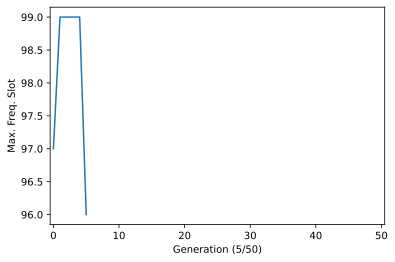

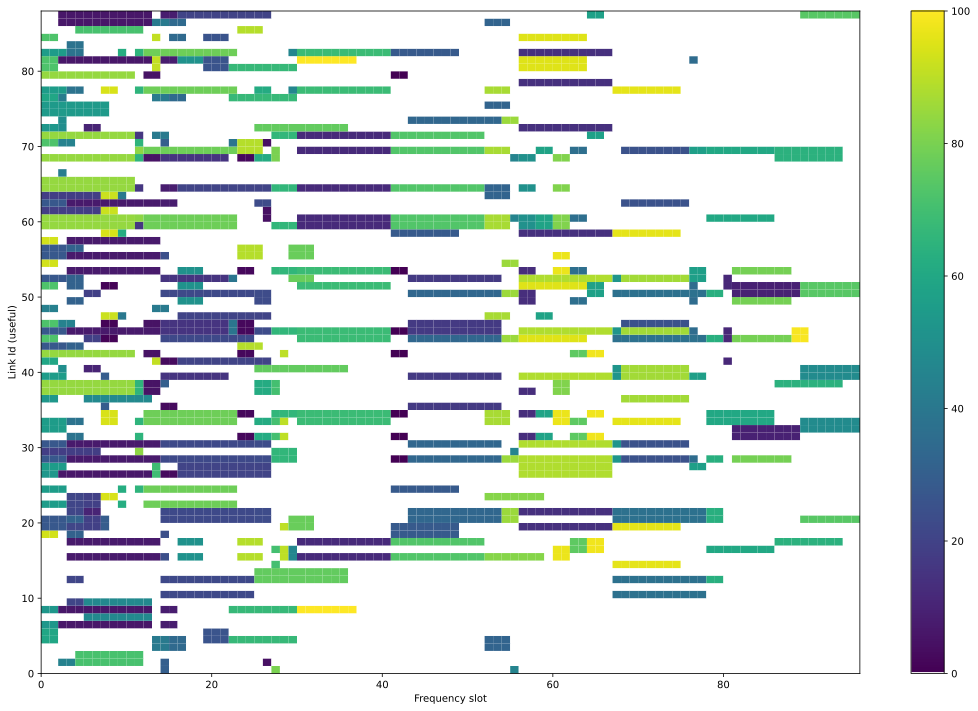

 ...

In [19]:
best = genetic_algorithm_plot(topology, 
                      k_shortest_paths, 
                      demands, 
                      modulations, 
                      population_size=100, elite_size=20, mutation_rate=0.01, generations=50)

### Evaluating the final solution

In [ ]:
plot_spectrum_assignment(best.slots_allocation[:, :best.get_max_freq_slot()], # only plots the part of spectrum that was actually used
                         values=False) # set to True to plot the demand IDs